In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import numpy as np
import pandas as pd
import awkward as ak
import tensorflow as tf
from tensorflow import keras

import matplotlib
#matplotlib.use("Agg")
matplotlib.rcParams["figure.figsize"] = [6.4 / 1.3, 4.8 / 1.3]
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from argparse import ArgumentParser
import mplhep as hep
import vector
import hist
from hist import Hist

from general import custom_objects, feat, table_to_numpy_visualization, load_normalization, SwitchLayer, HDF5File, MaxPassLayer, TitledModel
from model_bcls import make_model as make_model_b
from model_bcls import load_data as load_data_b
from model_tt import make_model, load_data as load_data_tt

In [2]:
particle_labels = {
    "bot": r"Bottom quark",
    "abot": r"Bottom antiquark",
    "lep": r"Lepton",
    "alep": r"Antilepton",
    "top": r"Top quark",
    "atop": r"Top antiquark",
    "ttbar": r"$\mathrm{t}\bar{\mathrm{t}}$",
    "wminus": r"$\mathrm{W}^{-}$ boson",
    "wplus": r"$\mathrm{W}^{+}$ boson",
    "met": "MET",
    "jet": "Jet"
}

obs_labels = {
    "pt": r"$p_{\mathrm{T}}$",
    "eta": r"$\eta$",
    "phi": r"$\varphi$",
    "x": r"$p_{x}$",
    "y": r"$p_{y}$",
    "z": r"$p_{z}$",
    "t": r"Energy",
    "mtt": r"$m_{\mathrm{t}\bar{\mathrm{t}}}$",
    "chel": r"$c_{\mathrm{hel}}$",
    "pttt": r"$p_{\mathrm{T},\mathrm{t}\bar{\mathrm{t}}}$",
}

obs_units = {
    "x": "GeV",
    "y": "GeV",
    "z": "GeV",
    "t": "GeV",
    "pt": "GeV",
    "mass": "GeV",
    "mtt": "GeV",
    "pttt": "GeV",
}


def get_label(observable):
    label = ""
    if "_" in observable:
        part, observable = observable.split("_")
        label += particle_labels.get(part, part) + " "
    label += obs_labels.get(observable, observable)
    if observable in obs_units:
        label += f" ({obs_units[observable]})"
    return label

def load_data(path, inputs, targets, norm):
    with HDF5File(path, "r") as f:
        data = f["data"]
        offset = f["offset"]
        scale = f["scale"]
    
    train_offset = ak.with_name(norm[0], "Dataframe")
    train_scale  = ak.with_name(norm[1], "Dataframe")
    
    # Flatten betch fields
    betch_fields = feat("betchtop", coord = "cart") + feat("betchatop", coord = "cart")
    for field in betch_fields:
        data[field] = ak.flatten(data[field])
    
    # Handling non convergence in sonnen
    sonnen_fields = feat("sonnentop", coord = "cart") + feat("sonnenatop", coord = "cart")
    sonnen_mask = (ak.num(data["sonnentop_t"]) != 1) | (ak.num(data["sonnenatop_t"]) != 1)
    
    for field in sonnen_fields:      
        # Use the mask to fill non-matching entries with None
        data[field] = ak.where(sonnen_mask, np.nan, data[field])
        # Flatten the field
        data[field] = ak.flatten(data[field], axis=None)
    
    # Add the fields to the targets
    targets = targets + betch_fields + sonnen_fields + ["dark_pt", "dark_phi"]
    
    data["weight"] = data["weight"] * scale["weight"] + offset["weight"]

    weight = np.asarray(data["weight"])
    data_x = []
    for input in inputs:
        data_input = ak.with_name(data[input], "Dataframe")
        data_input = (data_input * scale[input] + offset[input] - train_offset[input]) / train_scale[input]
        data_x.append(table_to_numpy_visualization(data_input, input))
    
    data_y = table_to_numpy_visualization(data, targets)
    truth = data_y * table_to_numpy_visualization(scale, targets) + table_to_numpy_visualization(offset, targets)
    truth = pd.DataFrame(truth, columns=targets)
    return data_x, truth, weight

def plot_observable(observable, norm, pred, truth, weight, bins=50, range=None, sonnen=None, betch=None):
    weight = np.asarray(weight)
    if range is None:
        offset = norm[0][observable]
        scale = norm[1][observable]
        range = (offset - 1.5 * scale, offset + 1.5 * scale)
        if observable == "top_mass":
            range = (169, 177)
    is_good = pred < 1e30
    mse = np.mean((pred[is_good] - truth[is_good]) ** 2)
    plt.hist(
        np.asarray(pred),
        weights=weight,
        range=range,
        bins=50,
        label=f"Network (MSE: {mse:.3})",
        facecolor=to_rgb("C0") + (0.5,),
        edgecolor="C0")
    plt.hist(
        np.asarray(truth),
        weights=weight,
        range=range,
        bins=50,
        label="Truth",
        facecolor=to_rgb("C1") + (0.5,),
        edgecolor="C1")
    if sonnen is not None:
        sonnen_mse = np.mean((sonnen - truth) ** 2)
        plt.hist(
            np.asarray(sonnen),
            weights=weight,
            range=range,
            bins=50,
            label=f"Analytic Sonnenschein (MSE: {sonnen_mse:.3})",
            facecolor=to_rgb("C2") + (0.5,),
            edgecolor="C2")
    if betch is not None:
        betch_mse = np.mean((betch - truth) ** 2)
        plt.hist(
            np.asarray(betch),
            weights=weight,
            range=range,
            bins=50,
            label=f"Analytic Betch (MSE: {betch_mse:.3})",
            facecolor=to_rgb("C3") + (0.5,),
            edgecolor="C3")
    plt.xlabel(get_label(observable))
    plt.ylabel("Events / bin")
    plt.margins(x=0)
    plt.legend()
    hep.cms.label(llabel="Private work (CMS simulation)", rlabel="", loc=0, fontsize=13)
    plt.tight_layout()
    plt.show()
    #plt.savefig(os.path.join(output, f"predtruth_{observable}.svg"))
    #plt.close()



def make_lorentzvec(prefix, truth):
    vec = {}
    for p in ["x", "y", "z", "t"]:
        name = f"{prefix}_{p}"
        if p == "t":
            p = "E"
        vec[p] = np.asarray(truth[name])
    return vector.obj(**vec)

def make_2dvec(prefix, truth):
    vec = {}
    for p in ["pt", "phi"]:
        name = f"{prefix}_{p}"
        vec[p] = np.asarray(truth[name]) 
    return vector.obj(rho=vec["pt"], phi=vec["phi"])

def compute_chel(top, atop, lep, alep):
    tt = top + atop
    ttboost = -tt.to_beta3()
    top_tt = top.boost(ttboost)
    atop_tt = atop.boost(ttboost)
    lep_tt = lep.boost(ttboost)
    alep_tt = alep.boost(ttboost)
    lep_hel = lep_tt.boost(-atop_tt.to_beta3())
    alep_hel = alep_tt.boost(-top_tt.to_beta3())
    chel = lep_hel.to_xyz().dot(alep_hel.to_xyz()) / lep_hel.mag / alep_hel.mag
    return chel


def featc(particle):
    return [f"{particle}_{x}" for x in ["x", "y", "z", "t"]]


def binned_mean(x, values, edges, idx=None, counts=None, return_unc=True):
    if idx is None:
        idx = np.digitize(x, edges) - 1
    if counts is None:
        counts = np.bincount(idx)
    bincounts = np.bincount(idx, weights=values, minlength=len(edges) - 1)
    mean = np.divide(bincounts, counts, where=counts != 0, out=np.zeros_like(counts, dtype=float))
    if return_unc:
        diff = values - mean[idx]
        diff_up = diff[diff > 0]
        diff_down = diff[diff < 0]
        one_sigma = 0.6827
        if len(diff_up) > 0:
            up = np.quantile(diff_up, one_sigma)
        else:
            up = 0
        if len(diff_down) > 0:
            down = np.quantile(abs(diff_down), one_sigma)
        else:
            down = 0
        return mean, mean + up, mean - down
    else:
        return mean

def switch_charge_label(label):
    if label.startswith("alep_"):
        return "lep_" + label[len("alep_"):]
    elif label.startswith("lep_"):
        return "alep_" + label[len("lep_"):]
    elif label.startswith("abot_"):
        return "bot_" + label[len("abot_"):]
    elif label.startswith("bot_"):
        return "abot_" + label[len("bot_"):]
    elif label.startswith("wminus_"):
        return "wplus_" + label[len("wminus_"):]
    elif label.startswith("wplus_"):
        return "wminus_" + label[len("wplus_"):]
    elif label.startswith("atop_"):
        return "top_" + label[len("atop_"):]
    elif label.startswith("top_"):
        return "atop_" + label[len("top_"):]
    else:
        return label


def find_switch(model):
    for layer in model.layers:
        if hasattr(layer, "layers"):
            try:
                return find_switch(layer)
            except ValueError:
                pass
        elif isinstance(layer, SwitchLayer):
            return layer
    else:
        raise ValueError("No switch in model")


def create_particle(prediction, model, index, norm, switch=False, mass=None):
    part = {}
    for i, title in enumerate(model.output_titles[index]):
        p = title.split("_")[-1]
        if switch:
            idx = model.output_titles[index].index(switch_charge_label(title))
        else:
            idx = model.output_titles[index].index(title)
        if p == "t":
            p = "E"
        part[p] = prediction[index][:, idx] * norm[1][title] + norm[0][title]
    if mass is not None:
        part["mass"] = mass
    part = vector.obj(**part)
    return part


def plot_particle(pred, particle_name, norm, truth, weight, sonnenpart=None):
    print('Plotting particle')
    for observable in feat(particle_name):
        print(observable)
        predval = getattr(pred, observable[len(f"{particle_name}_"):])
        if sonnenpart is not None:
            sonnen = getattr(sonnenpart, observable[len(f"{particle_name}_"):])
        else:
            sonnen = None
            print('Sonn in None')
        plot_observable(observable, norm, predval, truth[observable], weight, sonnen=sonnen)
        plot_2D_recogen(observable, norm, predval, truth[observable], sonnen=sonnen)
        plot_resbias(observable, norm, predval, truth[observable], sonnen=sonnen)
        print('')


def get_partidx(model, particle):
    titles = model.output_titles
    return [title[0].split("_")[0] for title in titles].index(particle)


In [3]:
def plot_resbias(observable, norm, pred, truth, bins=50, range=None, sonnen=None, betch=None, relative=None, adjust_limits=True):
    xlabel = get_label(observable)
    pred = np.asarray(pred)
    truth = np.asarray(truth)
    scale = None
    offset = None
    
    if range is None:
        offset = norm[0][observable]
        scale = norm[1][observable]
        if scale < 1e-10:
            return
        range = (offset - 1. * scale, offset + 1. * scale)
    if relative is None:
        relative = not (range[0] <= 0 and 0 <= range[1])
        
    print(xlabel, offset, scale, relative)
    
    edges = np.linspace(range[0], range[1], bins)
    is_inrange = (edges[0] <= truth) & (truth < edges[-1])
    truth = truth[is_inrange]
    pred = pred[is_inrange]
    idx = np.digitize(truth, edges) - 1
    counts = np.bincount(idx, minlength=bins - 1)
    if relative:
        err = (pred - truth) / truth
    else:
        err = pred - truth

    resp, resp_up, resp_down = binned_mean(truth, pred, edges, idx, counts)
    bias, bias_up, bias_down = binned_mean(truth, err, edges, idx, counts)
    resolution = np.sqrt(binned_mean(truth, err ** 2, edges, idx, counts, return_unc=False) - bias ** 2)

    if sonnen is not None:
        sonnen = np.asarray(sonnen)[(is_inrange)]
        sonnen_mask = ~np.isnan(sonnen)
        sonnen = sonnen[sonnen_mask]
        truth_sonnen = truth[sonnen_mask]
        
        # Debugging print statements
        print(f"Length of sonnen: {len(sonnen)}, Length of truth_sonnen: {len(truth_sonnen)}")
        
        if relative:
            err_son = (sonnen - truth_sonnen) / truth_sonnen
        else:
            err_son = sonnen - truth_sonnen

        # Recalculate idx for truth_sonnen
        idx_sonnen = np.digitize(truth_sonnen, edges) - 1
        
        resp_son, resp_up_son, resp_down_son = binned_mean(truth_sonnen, sonnen, edges, idx_sonnen, counts=None)
        bias_son, bias_up_son, bias_down_son = binned_mean(truth_sonnen, err_son, edges, idx_sonnen, counts=None)
        resolution_son = np.sqrt(binned_mean(truth_sonnen, err_son ** 2, edges, idx_sonnen, counts=None, return_unc=False) - bias_son ** 2)

    if betch is not None:
        betch = np.asarray(betch)[(is_inrange)]
        betch_mask = ~np.isnan(betch)
        betch = betch[betch_mask]
        truth_betch = truth[betch_mask]
        
        # Debugging print statements
        print(f"Length of betch: {len(betch)}, Length of truth_betch: {len(truth_betch)}")
        
        if relative:
            err_betch = (betch - truth_betch) / truth_betch
        else:
            err_betch = betch - truth_betch

        # Recalculate idx for truth_betch
        idx_betch = np.digitize(truth_betch, edges) - 1
        
        resp_betch, resp_up_betch, resp_down_betch = binned_mean(truth_betch, betch, edges, idx_betch, counts=None)
        bias_betch, bias_up_betch, bias_down_betch = binned_mean(truth_betch, err_betch, edges, idx_betch, counts=None)
        resolution_betch = np.sqrt(binned_mean(truth_betch, err_betch ** 2, edges, idx_betch, counts=None, return_unc=False) - bias_betch ** 2)

    line = plt.step(edges, np.r_[resp[0], resp], label="Network")[0]
    plt.fill_between(edges, np.r_[resp_down[0], resp_down], np.r_[resp_up[0], resp_up], step="pre", color=line.get_color(), alpha=0.5)
    if sonnen is not None:
        line = plt.step(edges, np.r_[resp_son[0], resp_son], label="Analytic Sonnenschein")[0]
        plt.fill_between(edges, np.r_[resp_down_son[0], resp_down_son], np.r_[resp_up_son[0], resp_up_son], step="pre", color=line.get_color(), alpha=0.5)
    if betch is not None:
        line = plt.step(edges, np.r_[resp_betch[0], resp_betch], label="Analytic Betch")[0]
        plt.fill_between(edges, np.r_[resp_down_betch[0], resp_down_betch], np.r_[resp_up_betch[0], resp_up_betch], step="pre", color=line.get_color(), alpha=0.5)

    plt.legend()
    plt.xlabel(f"True {xlabel}")
    if observable in obs_units:
        plt.ylabel(f"Response ({obs_units[observable]})")
    else:
        plt.ylabel("Response")
    plt.grid()
    plt.margins(x=0)
    hep.cms.label(llabel="Private work (CMS simulation)", rlabel="", loc=0, fontsize=13)
    plt.tight_layout()
    plt.show()

    overall = np.mean(np.mean(abs(err)))
    line = plt.step(edges, np.r_[bias[0], bias], label=f"Network (mean abs {overall:.3})")[0]
    plt.fill_between(edges, np.r_[bias_down[0], bias_down], np.r_[bias_up[0], bias_up], step="pre", color=line.get_color(), alpha=0.5)
    if sonnen is not None:
        overall = np.mean(np.mean(abs(err_son)))
        line = plt.step(edges, np.r_[bias_son[0], bias_son], label=f"Analytic Sonnenschein (mean abs {overall:.3})")[0]
        plt.fill_between(edges, np.r_[bias_down_son[0], bias_down_son], np.r_[bias_up_son[0], bias_up_son], step="pre", color=line.get_color(), alpha=0.5)
    if betch is not None:
        overall = np.mean(np.mean(abs(err_betch)))
        line = plt.step(edges, np.r_[bias_betch[0], bias_betch], label=f"Analytic Betch (mean abs {overall:.3})")[0]
        plt.fill_between(edges, np.r_[bias_down_betch[0], bias_down_betch], np.r_[bias_up_betch[0], bias_up_betch], step="pre", color=line.get_color(), alpha=0.5)
    
    plt.legend()
    if adjust_limits:
        if plt.ylim()[0] < -2:
            plt.ylim(-2, plt.ylim()[1])
        if plt.ylim()[1] > 2:
            plt.ylim(plt.ylim()[0], 2)
    plt.xlabel(f"True {xlabel}")
    if relative:
        plt.ylabel("Relative bias")
    else:
        plt.ylabel("Bias")
    plt.grid()
    plt.margins(x=0)
    hep.cms.label(llabel="Private work (CMS simulation)", rlabel="", loc=0, fontsize=13)
    plt.tight_layout()
    plt.show()

    overall = np.sqrt(np.mean(err ** 2))
    plt.step(edges, np.r_[resolution[0], resolution], label=f"Network (mean {overall:.3})")
    if sonnen is not None:
        overall = np.sqrt(np.mean(err_son ** 2))
        plt.step(edges, np.r_[resolution_son[0], resolution_son], label=f"Analytic Sonnenschein (mean {overall:.3})")
    if betch is not None:
        overall = np.sqrt(np.mean(err_betch ** 2))
        plt.step(edges, np.r_[resolution_betch[0], resolution_betch], label=f"Analytic Betch (mean {overall:.3})")

    plt.legend()
    plt.ylim(0, plt.ylim()[1])
    if adjust_limits:
        if plt.ylim()[1] > 2:
            plt.ylim(0, 2)
        plt.xlabel(f"True {xlabel}")
        if relative:
            plt.ylabel("Resolution")
        else:
            plt.ylabel("Standard deviation")
    plt.grid()
    plt.margins(x=0)
    hep.cms.label(llabel="Private work (CMS simulation)", rlabel="", loc=0, fontsize=13)
    plt.tight_layout()
    plt.show()

In [4]:
def plot_2D_recogen(observable, norm, pred, truth, bins=500, range=None, sonnen=None, betch=None, density=False):
    label  = get_label(observable)
    scale  = None
    offset = None
    
    if range is None:
        offset = norm[0][observable]
        scale = norm[1][observable]
        if scale < 1e-10:
            return
        range = (offset - 1.* scale, offset + 1. * scale)
    print(range[0], range[1])
    
    # -------------- NN 2D plot --------------
        
    h_NN = Hist(
        hist.axis.Regular(bins, range[0], range[1], name="gen", label="Gen "    + label, flow=False),
        hist.axis.Regular(bins, range[0], range[1], name="reco",label="RecoNN " + label, flow=False),
    )
    
    h_NN.fill(truth, pred)
    
    if density:
        h_NN = h_NN / np.sum(h_NN.values())
    
    
    h_NN.plot2d(cmap="plasma")
    plt.suptitle('Generated vs Reco NN ' + label)
    hep.cms.label(llabel="Private work (CMS simulation)", rlabel="", loc=0, fontsize=13)
    plt.tight_layout()
    
    plt.show()
    #plt.savefig(os.path.join(output, f'recoNN_gen_{observable}.svg'))
    #plt.close() 
      
    # -------------- Sonn 2D plot --------------
    
    if sonnen is not None:
        h_sonn = Hist(
            hist.axis.Regular(bins, range[0], range[1], name="gen", label="Gen "    + label, flow=False),
            hist.axis.Regular(bins, range[0], range[1], name="reco",label="Reco Sonn " + label, flow=False),
        )

        h_sonn.fill(truth, sonnen)

        if density:
            h_sonn = h_sonn / np.sum(h_sonn.values())


        h_sonn.plot2d(cmap="plasma")
        plt.suptitle('Generated vs Reco Sonn ' + label)
        hep.cms.label(llabel="Private work (CMS simulation)", rlabel="", loc=0, fontsize=13)
        plt.tight_layout()  
        plt.margins(x=0)

        plt.show()
        #plt.savefig(os.path.join(output, f'recosonn_gen_{observable}.svg'))
        #plt.close()

    # -------------- Betch 2D plot --------------

    if betch is not None:
        h_betch = Hist(
            hist.axis.Regular(bins, range[0], range[1], name="gen", label="Gen "    + label, flow=False),
            hist.axis.Regular(bins, range[0], range[1], name="reco",label="Reco Betch " + label, flow=False),
        )

        h_betch.fill(truth, betch)

        if density:
            h_betch = h_betch / np.sum(h_betch.values())


        h_betch.plot2d(cmap="plasma")
        plt.suptitle('Generated vs Reco Betch' + label)
        hep.cms.label(llabel="Private work (CMS simulation)", rlabel="", loc=0, fontsize=13)
        plt.tight_layout()  
        plt.margins(x=0)

        plt.show()
        #plt.savefig(os.path.join(output, f'recobetch_gen_{observable}.svg'))
        #plt.close()

## Main

In [5]:
validate_mass = 500
DM_frac       = 20

In [6]:
traindata    = f"/nfs/dust/cms/user/coradine/DATA/DM_{DM_frac}_SM_{100-DM_frac}/traindata.hdf5"
validatedata = f"/nfs/dust/cms/user/stafford/For_Emanuele/reconn/2907_nn_inputs/_TTbarDMJets_Dilepton_scalar_LO_Mchi_1_Mphi_{validate_mass}_TuneCP5_13TeV_madgraph_mcatnlo_pythia8/validatedata.hdf5"
modelb       = f"/nfs/dust/cms/user/coradine/Top-Pair-Reco-NN/DM_{DM_frac}_SM_{100-DM_frac}/model_bcls.hdf5"
model_tt     = f"/nfs/dust/cms/user/coradine/Top-Pair-Reco-NN/DM_{DM_frac}_SM_{100-DM_frac}/model_tt.hdf5"

SM_data      = "/nfs/dust/cms/user/stafford/For_Emanuele/reconn/2907_nn_inputs/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/validatedata.hdf5" 

output       = ""

norm = load_normalization(traindata)
validnorm = load_normalization(validatedata)

# TODO: find a more elegant way to load the model_b

#Reconstruct the model_b as has been done in the model_bcls file

# Provided model construction details
features1 = feat("jet") + ["jet_btag"]
features2 = feat("alep") + feat("lep") + ["met_pt", "met_phi", "met_x", "met_y"]
train    = load_data_b(traindata, features1, features2)
validate = load_data_b(validatedata, features1, features2)

model_b = make_model_b(
    [t.shape for t in train[0]],  # Input shapes
    [features1, features2],       # Input titles
    [2, 0],                       # Number of layers per input
    2,                            # Number of layers after concatenation
    200,                          # Number of nodes per layer
    "relu",                       # Activation function
    0.25,                         # Dropout rate
    train[1].shape[1],            # Number of outputs
    [],                           # Output titles
    0.0003,                       # Learning rate
    0                             # Learning rate decay
)

model_b.load_weights(modelb)

# Add the MaxPassLayer and continue growing the tt model
b_out = MaxPassLayer(2)([model_b.output, model_b.inputs[0]])
model_bbar = TitledModel(
    model_b.input_titles,
    [p + t.split("_")[1] for t in model_b.input_titles[0] for p in ("bot_", "abot_")],
    inputs=model_b.inputs, outputs=[b_out])
model_bbar.trainable = False

inputs = model_b.input_titles + [["met_pt", "met_phi", "met_x", "met_y"] + feat("lep") + feat("alep")]
targets = [
    ["top_x", "top_y", "top_z", "top_mass"],
    ["atop_x", "atop_y", "atop_z", "atop_mass"],
]

train = load_data_tt(traindata, inputs, targets)
validate = load_data_tt(validatedata, inputs, targets)
model = make_model([t.shape for t in train[0]], inputs, [model_bbar], [0, 2], 3, 800, "relu", 0.25, targets, 0.001, 0)
norm = load_normalization(traindata)

model.load_weights(model_tt)

loading common data

In [7]:
targets = feat("top") + feat("atop") +\
          feat("genlep") + feat("genalep") +\
          feat("genbot") + feat("genabot") + feat("ttbar") +\
          feat("gendmmed", coord = "cart") +\
          feat("lep") + feat("alep") +\
          feat("bot") + feat("abot") + ["mtt", "chel"] + ["met_pt", "met_phi"]
           
#
data_x, truth, weight = load_data(validatedata, model.input_titles, targets, norm)

# Generated quantities
top     = make_lorentzvec("top", truth)
atop    = make_lorentzvec("atop", truth)
genlep  = make_lorentzvec("genlep", truth)
genalep = make_lorentzvec("genalep", truth)
genbot  = make_lorentzvec("genbot", truth)
genabot = make_lorentzvec("genabot", truth)
gendmmed   = make_lorentzvec("gendmmed", truth)

# reconstructed by algoritms
lep  = make_lorentzvec("lep", truth)
alep = make_lorentzvec("alep", truth)
bot  = make_lorentzvec("bot", truth)
abot = make_lorentzvec("abot", truth)
MET  = make_2dvec("met", truth)

sonnentop   = make_lorentzvec("sonnentop", truth)
sonnenatop  = make_lorentzvec("sonnenatop", truth)
betchtop    = make_lorentzvec("betchtop", truth)
betchatop   = make_lorentzvec("betchatop", truth)
dm_betch = make_2dvec("dark", truth)

In [8]:
# Loading SM file
targets_SM =  feat("top") + feat("atop") +\
              feat("genlep") + feat("genalep") +\
              feat("genbot") + feat("genabot") + feat("ttbar") +\
              feat("lep") + feat("alep") +\
              feat("bot") + feat("abot") + ["mtt", "chel"] + ["met_pt", "met_phi"]
           
#
data_x_SM, truth_SM, weight_SM = load_data(SM_data, model.input_titles, targets_SM, norm)

# Generated quantities
top_SM     = make_lorentzvec("top", truth_SM)
atop_SM    = make_lorentzvec("atop", truth_SM)
genlep_SM  = make_lorentzvec("genlep", truth_SM)
genalep_SM = make_lorentzvec("genalep", truth_SM)
genbot_SM  = make_lorentzvec("genbot", truth_SM)
genabot_SM = make_lorentzvec("genabot", truth_SM)

# reconstructed by algoritms
lep_SM  = make_lorentzvec("lep", truth_SM)
alep_SM = make_lorentzvec("alep", truth_SM)
bot_SM  = make_lorentzvec("bot", truth_SM)
abot_SM = make_lorentzvec("abot", truth_SM)
MET_SM  = make_2dvec("met", truth_SM)

sonnentop_SM   = make_lorentzvec("sonnentop", truth_SM)
sonnenatop_SM  = make_lorentzvec("sonnenatop", truth_SM)
betchtop_SM    = make_lorentzvec("betchtop", truth_SM)
betchatop_SM   = make_lorentzvec("betchatop", truth_SM)
dm_betch_SM    = make_2dvec("dark", truth_SM)

In [9]:
nan_count = truth['betchtop_t'].isna().sum()

print(f"Number of NaN values in betch: {nan_count}")

nan_count = truth['sonnentop_t'].isna().sum()

print(f"Number of NaN values in sonnen: {nan_count}")

Number of NaN values in betch: 625
Number of NaN values in sonnen: 6240


In [10]:
# Use NN to reconstruct top quarks
#os.makedirs(output, exist_ok=True)

prediction = model.predict(data_x, batch_size=2**14)
top_pred   = create_particle(prediction, model, get_partidx(model, "top"), norm)
atop_pred  = create_particle(prediction, model, get_partidx(model, "atop"), norm)
ttbar_pred = top_pred + atop_pred


1/1 [==============================] - 1s 553ms/step


In [11]:
# Use NN to reconstruct top quarks in SM dataset

prediction_SM = model.predict(data_x_SM, batch_size=2**14)
top_pred_SM   = create_particle(prediction_SM, model, get_partidx(model, "top"), norm)
atop_pred_SM  = create_particle(prediction_SM, model, get_partidx(model, "atop"), norm)
ttbar_pred_SM = top_pred_SM + atop_pred_SM


19/19 [==============================] - 3s 171ms/step


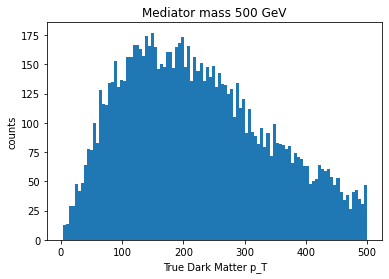

In [12]:
plt.hist(gendmmed.pt[gendmmed.pt<500], bins=100)
plt.title(f'Mediator mass {validate_mass} GeV')
plt.xlabel('True Dark Matter p_T')
plt.ylabel('counts')
plt.show()


In [13]:
# Reconstruct DM with NN
neutrinos_pred = top_pred + atop_pred - lep - alep - bot - abot
neutrinos_MET_pred = vector.obj(rho = neutrinos_pred.pt, phi=neutrinos_pred.phi)
dm_MET_pred = (MET - neutrinos_MET_pred).rho

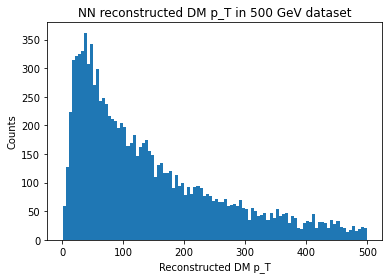

In [14]:
plt.hist(dm_MET_pred[dm_MET_pred<500], bins=100)
plt.title(f"NN reconstructed DM p_T in {validate_mass} GeV dataset")
plt.xlabel("Reconstructed DM p_T")
plt.ylabel("Counts")
plt.show()

In [15]:
# Reconstruct DM with NN in SM case
neutrinos_pred_SM = top_pred_SM + atop_pred_SM - lep_SM - alep_SM - bot_SM - abot_SM
neutrinos_MET_pred_SM = vector.obj(rho = neutrinos_pred_SM.pt, phi=neutrinos_pred_SM.phi)
dm_MET_pred_SM = (MET_SM - neutrinos_MET_pred_SM).rho

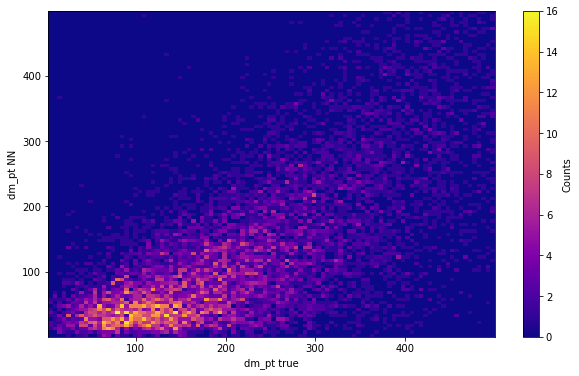

In [16]:
mask = (dm_MET_pred<500) & (gendmmed.pt < 500)
plt.figure(figsize=(10, 6))
plt.hist2d(gendmmed.pt[mask], dm_MET_pred[mask], bins=100, cmap='plasma')
plt.colorbar(label='Counts')
plt.xlabel('dm_pt true')
plt.ylabel('dm_pt NN')
plt.show()

In [17]:
# Reconstruct DM with Sonn
neutrinos_sonn = sonnentop + sonnenatop - lep - alep - bot - abot
neutrinos_MET_sonn = vector.obj(rho = neutrinos_sonn.pt, phi=neutrinos_sonn.phi)
dm_MET_sonn = (MET - neutrinos_MET_sonn).rho

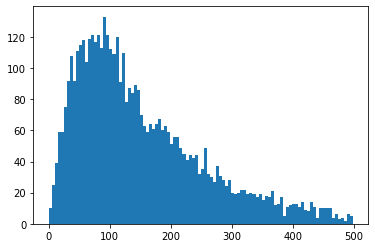

In [18]:
plt.hist(dm_MET_sonn[dm_MET_sonn<500], bins=100)
plt.show()

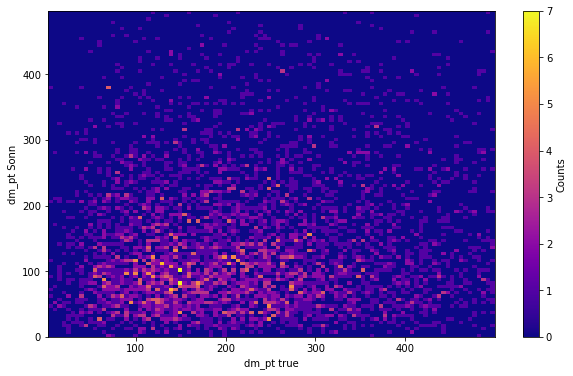

In [19]:
mask = (dm_MET_sonn<500) & (gendmmed.pt < 500)
plt.figure(figsize=(10, 6))
plt.hist2d(gendmmed.pt[mask], dm_MET_sonn[mask], bins=100, cmap='plasma')
plt.colorbar(label='Counts')
plt.xlabel('dm_pt true')
plt.ylabel('dm_pt Sonn')
plt.show()

In [ ]:
# Reconstruct DM with Betch
dm_pt_betch    = dm_betch.rho
dm_pt_betch_SM = dm_betch_SM.rho

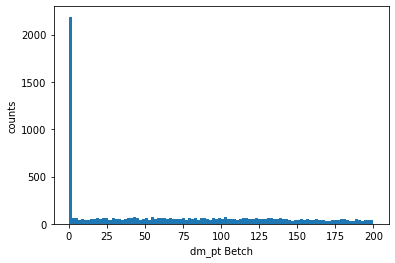

In [21]:
plt.hist(dm_pt_betch[(dm_pt_betch<200)], bins=100)
plt.xlabel('dm_pt Betch')
plt.ylabel('counts')
plt.show()

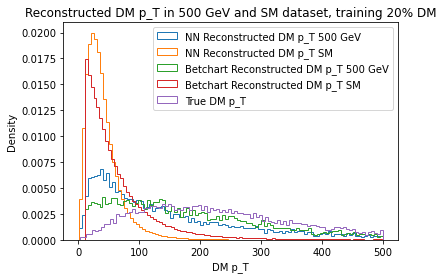

In [22]:
right_limit = 500
plt.hist(dm_MET_pred[dm_MET_pred < right_limit], bins=100, histtype='step', label=f"NN Reconstructed DM p_T {validate_mass} GeV", density=True)
plt.hist(dm_MET_pred_SM[dm_MET_pred_SM < right_limit], bins=100, histtype='step', label="NN Reconstructed DM p_T SM", density=True)

plt.hist(dm_pt_betch[(dm_pt_betch < right_limit) & (dm_pt_betch > 10)], bins=100, histtype='step', label=f"Betchart Reconstructed DM p_T {validate_mass} GeV", density=True)
plt.hist(dm_pt_betch_SM[(dm_pt_betch_SM < right_limit) & (dm_pt_betch_SM > 10)], bins=100, histtype='step', label="Betchart Reconstructed DM p_T SM", density=True)

plt.hist(gendmmed.pt[gendmmed.pt < right_limit], bins=100, histtype='step', label="True DM p_T", density=True)
# Add a title and labels
plt.title(f"Reconstructed DM p_T in {validate_mass} GeV and SM dataset, training {DM_frac}% DM")
plt.xlabel("DM p_T")
plt.ylabel("Density")

# Add a legend to differentiate between the two histograms
plt.legend()

# Display the plot
plt.show()

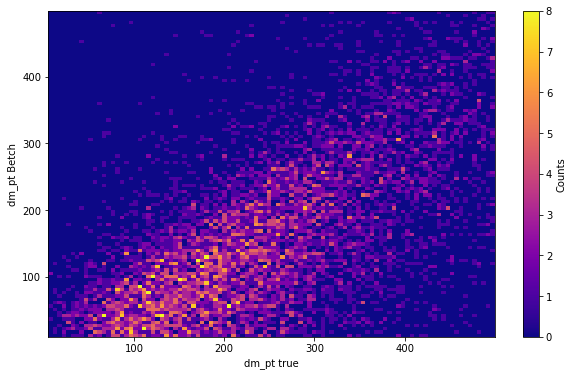

In [23]:
mask = (dm_pt_betch<500) & (gendmmed.pt < 500) & (dm_pt_betch>10)
plt.figure(figsize=(10, 6))
plt.hist2d(gendmmed.pt[mask], dm_pt_betch[mask], bins=100, cmap='plasma')
plt.colorbar(label='Counts')
plt.xlabel('dm_pt true')
plt.ylabel('dm_pt Betch')
plt.show()

In [24]:
truth["gendmmed_pt"] = gendmmed.pt 

10 500


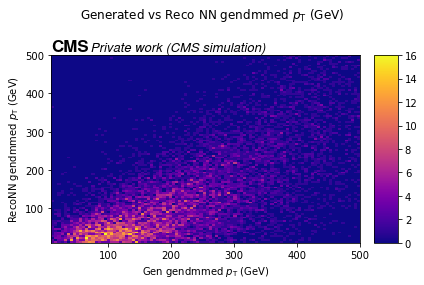

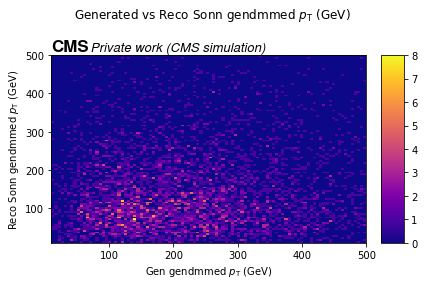

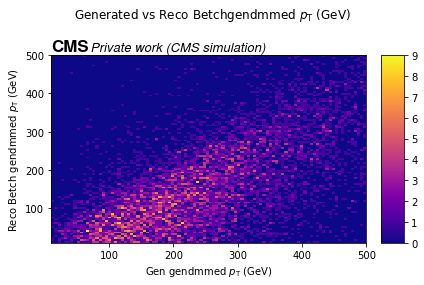

In [25]:
predval = dm_MET_pred
sonnen  = dm_MET_sonn
betch   = dm_pt_betch
plot_2D_recogen("gendmmed_pt", validnorm, predval, truth["gendmmed_pt"], bins = 100, sonnen=sonnen, betch = betch, range=(10, 500))

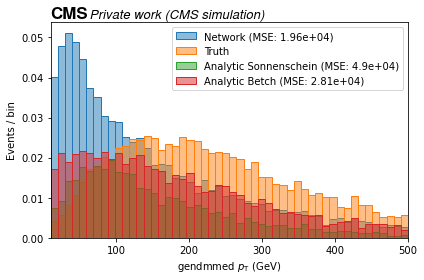

gendmmed $p_{\mathrm{T}}$ (GeV) None None True
Length of sonnen: 4469, Length of truth_sonnen: 4469
Length of betch: 9642, Length of truth_betch: 9642


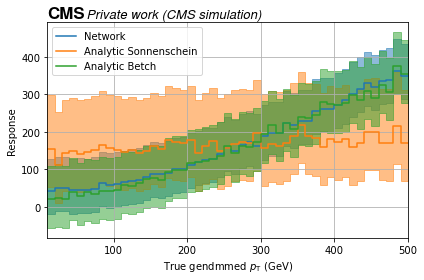

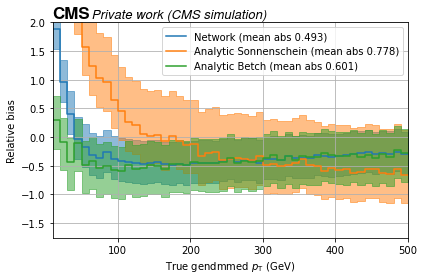

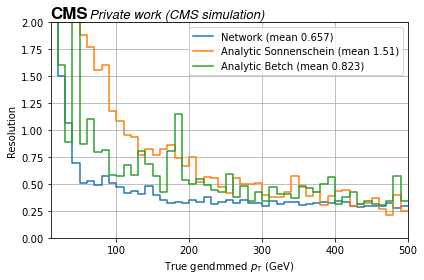

In [26]:
mtt_pred   = dm_MET_pred
mtt_sonnen = dm_MET_sonn
mtt_betch  = dm_pt_betch
plot_observable("gendmmed_pt", validnorm, mtt_pred, truth["gendmmed_pt"], weight, sonnen=mtt_sonnen, betch = mtt_betch, range=(10, 500))
plot_resbias("gendmmed_pt", validnorm, mtt_pred, truth["gendmmed_pt"], sonnen=mtt_sonnen, betch = mtt_betch,range=(10, 500), relative=True, adjust_limits=True)

standard plot validation

Plotting particle
top_x


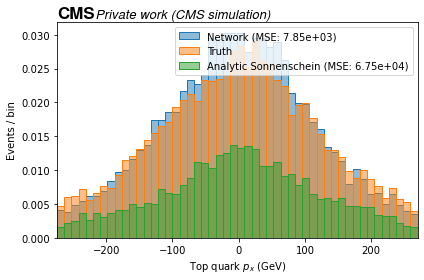

-183.5875484970195 179.18994986274333


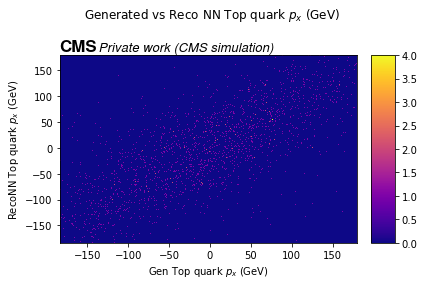

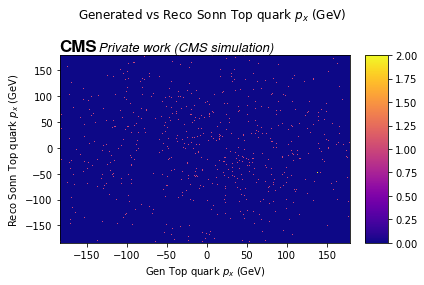

Top quark $p_{x}$ (GeV) -2.198799317138081 181.38874917988142 False
Length of sonnen: 3632, Length of truth_sonnen: 3632


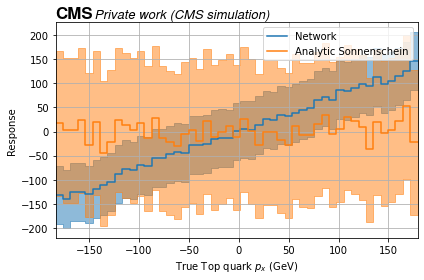

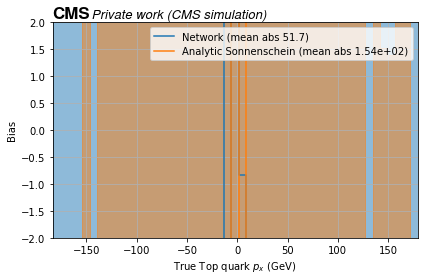

KeyboardInterrupt: 

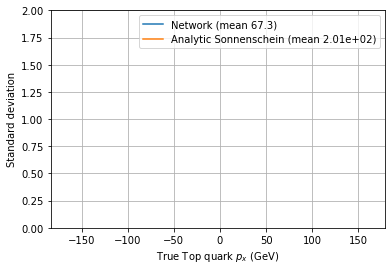

In [27]:
plot_particle(top_pred, "top", validnorm, truth, weight, sonnentop)
#plot_particle(atop_pred, "atop", validnorm, truth, weight, sonnenatop)
#plot_particle(ttbar_pred, "ttbar", validnorm, truth, weight, sonnentop + sonnenatop)

In [ ]:
mtt_pred = ttbar_pred.mass
mtt_sonnen = (sonnentop + sonnenatop).mass
plot_observable("mtt", validnorm, mtt_pred, truth["mtt"], weight, sonnen=mtt_sonnen, range=(300, 1200))
plot_resbias("mtt", validnorm, mtt_pred, truth["mtt"], sonnen=mtt_sonnen, range=(300, 1200))

In [ ]:
chel = compute_chel(top, atop, genlep, genalep)
chel_sonnen = compute_chel(sonnentop, sonnenatop, lep, alep)
pred = compute_chel(top_pred, atop_pred, lep, alep)

In [ ]:
plot_observable("chel", validnorm, pred, chel, weight, range=(-1, 1), sonnen=chel_sonnen)
plot_resbias("chel", validnorm, pred, chel, sonnen=chel_sonnen, range=(-1, 1), relative=False)

In [ ]:
dalpha = top.to_xyz().dot(atop.to_xyz()) / top.mag / atop.mag
dalpha_pred = top_pred.to_xyz().dot(atop_pred.to_xyz()) / top_pred.mag / atop_pred.mag
dalpha_sonnen = sonnentop.to_xyz().dot(sonnenatop.to_xyz()) / sonnentop.mag / sonnenatop.mag
plot_observable("dalpha", validnorm, dalpha_pred, dalpha, weight, range=(-1, 1), sonnen=dalpha_sonnen)
plot_resbias("dalpha", validnorm, dalpha_pred, dalpha, sonnen=dalpha_sonnen, range=(-1, 1), relative=False)

In [ ]:
plot_particle(atop_pred, "atop", validnorm, truth, weight, sonnenatop)

In [ ]:
plot_particle(atop_pred, "top", validnorm, truth, weight, sonnenatop)

In [ ]:
plot_resbias("mtt", validnorm, mtt_pred, truth["mtt"], sonnen=mtt_sonnen, range=(300, 1200))

In [ ]:
plot_2D_recogen("mtt", validnorm, mtt_pred, truth["mtt"], bins = 100, sonnen=mtt_sonnen, range=(300, 600))